# Getting started

The package we will use for our network analysis is `igraph`. There are also other packages out there for Python, such as `networkx` or `graphtool`, but we will not use them during this course. First, we will load all required packages.

In [4]:
# Networks
import igraph as ig
import leidenalg

# Computation
import numpy as np
np.random.seed(0)
import scipy
import random
random.seed(0)

# Data
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Note that at any time, you can get some information by pressing Shift-Tab when your cursor is on some function, and simply Tab to autocomplete some value.

We can create a graph ourselves, adding vertices and edges as we go.

In [5]:
G = ig.Graph(directed=False)
G.add_vertices(n=4)
G.add_edges([(0, 1),
             (0, 2),
             (0, 3),
             (1, 2),
             (1, 3),
             (2, 3)])

We can get a summary of the graph, providing some basic information on the graph

In [6]:
G.summary()

'IGRAPH U--- 4 6 -- '

The result indicates this graph is undirected (indicated by the `U`) has 4 nodes and 6 edges. The information on the number of nodes and edges can also be obtained using functions.

In [7]:
n = G.vcount()
m = G.ecount()
print('{0} nodes, {1} edges'.format(n, m))

4 nodes, 6 edges


In the remainder of this exercise, we will work with various networks, that need to be downloaded. There is one exception, a network that has become so famous that it is built in `igraph`: the karate club network constructed by [Zachary (1977)](https://www.jstor.org/stable/3629752?seq=1#page_scan_tab_contents).

In [8]:
G = ig.Graph.Famous('Zachary')

You can plot the graph easily

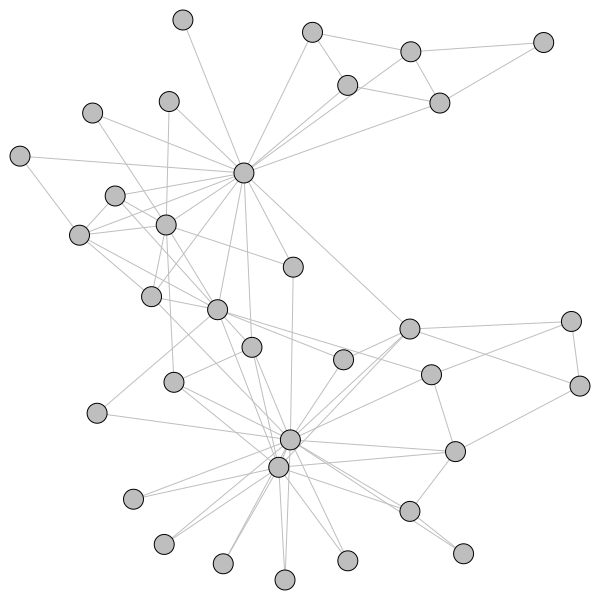

In [9]:
G['layout'] = G.layout_fruchterman_reingold()
G.vs['color'] = 'gray'
G.es['color'] = 'gray'
ig.plot(G)

The most basic elements of any graph are the *nodes* and the connection between the nodes, called *edges*. Nodes are also called *vertices* and edges are also called *links*. These words will be used interchangebly. Vertices and edges are the terms that are most often used in graph theory, while nodes and links are more common in (social) network analysis. Sometimes, you also see the term *tie* or *arc* for referring to an edge.

In `igraph` the terms vertex and edges are used throughout, and they can be accessed through a so-called `VertexSequence` and `EdgeSequence`. You can make different selections of vertices and edges, either based on attributes or simply specifying specific (vertex or edge) indices. The functionality on vertex and edge sequences is quite extensive. The following just demonstrates one possibility.

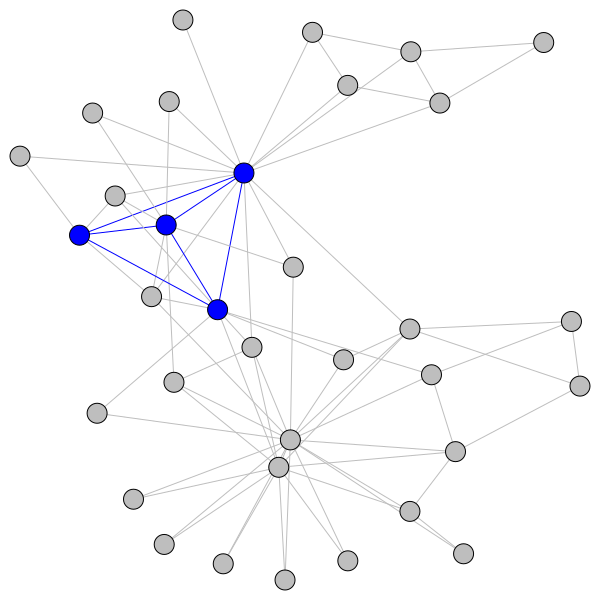

In [10]:
vs = G.vs[[0, 1, 2, 3]]
es = G.es.select(_within=vs)
vs['color'] = 'blue'
es['color'] = 'blue'
ig.plot(G)

The nodes that are linked to another node are called the *neighbors* of a node. The number of neighbors is called the *degree* of a node.

In [11]:
neighbors = G.neighbors(4)
print(neighbors, G.degree(4))

[0, 6, 10] 3


## Paths

One of the most basic operations on any network is finding a *path* from one node to another node, not unlike finding a route from one city to another using some navigational software.

In [12]:
edge_paths = G.get_shortest_paths(v=16, to=15, output='epath')
edge_paths

[[39, 4, 1, 28, 48]]

This retrieves a shortest path between node `16` and node `15`. It returns the *indices* of the edges because we set `output='epath'`. In this case there is only one path of 5 edges long. We can also get the endpoints of those edges, so that the path becomes a bit more clear.

In [13]:
edge_path = G.es[edge_paths[0]];
[(edge.source, edge.target) for edge in edge_path]

[(5, 16), (0, 5), (0, 2), (2, 32), (15, 32)]

We can also get the same path in terms of vertices

In [14]:
vertex_path = G.vs[G.get_shortest_paths(v=16, to=15, output='vpath')[0]]
[v.index for v in vertex_path]

[16, 5, 0, 2, 32, 15]

We can visualize this path as follows.

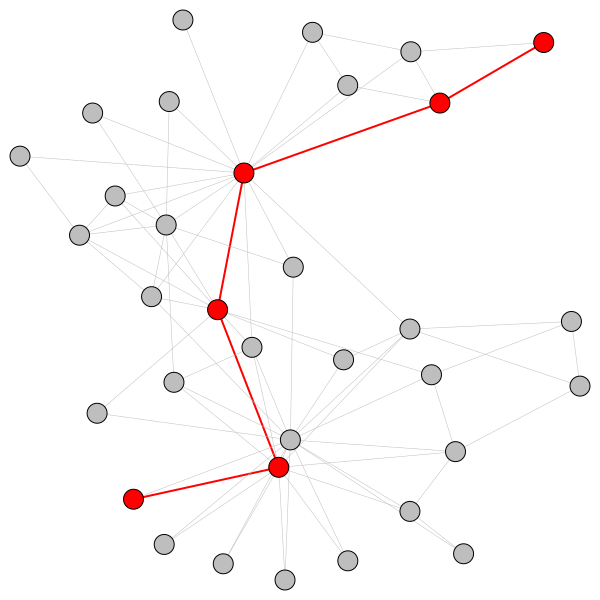

In [15]:
G.vs['color'] = 'gray'
vertex_path['color'] = 'red'

G.es['color'] = 'gray'
G.es['width'] = 0.5
edge_path['color'] = 'red'
edge_path['width'] = 2

ig.plot(G)

Rather than determining the actual shortest paths, we may also simply be interested in the distance between two nodes.

In [16]:
G.shortest_paths(source=16, target=15)

[[5]]

This only provides the actual length of the path (5 edges) rather than the actual path. We can also use this function to get the distance of all nodes to all other nodes. This is conveniently represented as a matrix, for which the `numpy` library is especially well suited.

In [17]:
distances = np.array(G.shortest_paths())
distances

array([[0, 1, 1, ..., 1, 2, 2],
       [1, 0, 1, ..., 2, 2, 2],
       [1, 1, 0, ..., 2, 1, 2],
       ...,
       [1, 2, 2, ..., 0, 1, 1],
       [2, 2, 1, ..., 1, 0, 1],
       [2, 2, 2, ..., 1, 1, 0]])

The largest distance from a node to any other node is called the *eccentricity*. If a node has a very high eccentricity, it is a bit peripheral. If a node has a very low eccentricity, it means that it is relatively close to to all other nodes, and that it is in the center of the graph in a certain sense.

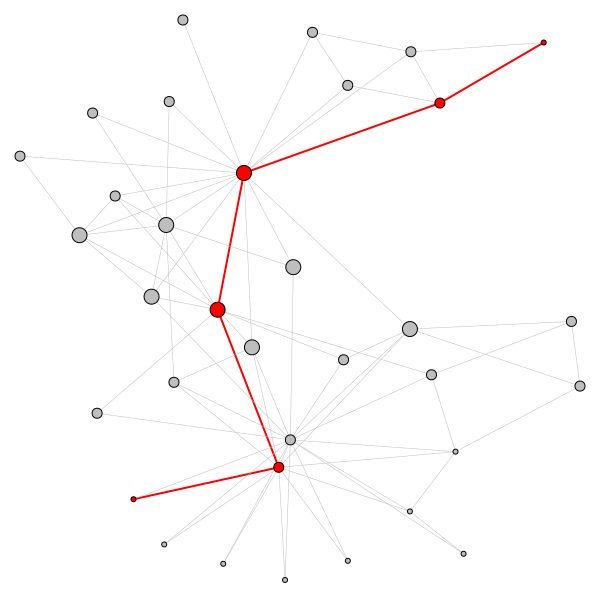

In [18]:
eccentricity = distances.max(1)
ig.plot(G, vertex_size=5*(6 - eccentricity))

The minimum eccentricity is called the *radius* of the graph and the maximum eccentricity is called the *diameter*. The diameter of any graph is always larger than the radius and smaller than twice the radius.

The network we currently look at is connected, which is not necessarily the case. It can consist of multiple components. Let us delete a number of edges so that we get a network with two components.

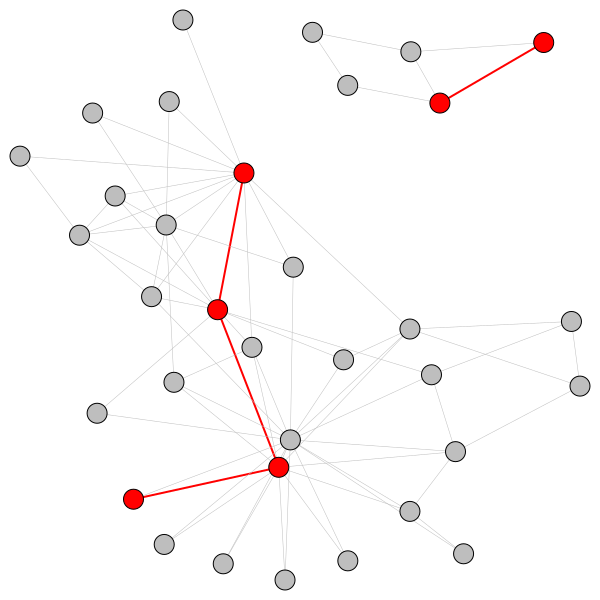

In [19]:
G.delete_edges(G.es.select(_between=[(4, 5, 6, 10), (0,)]))
ig.plot(G)

The path we constructed earlier is now no longer connected. In this case, there is no longer any path between the two nodes at all. The distance between the two nodes in hence infinitely large.

In [20]:
G.shortest_paths(source=16, target=15)

[[inf]]

There is now no longer a path between any two nodes, and the graph is then no longer said to be *connected*.

In [21]:
G.is_connected()

False

The network is now said to be *disconnected* and the different parts of the network that still are connected are called *connected components*.

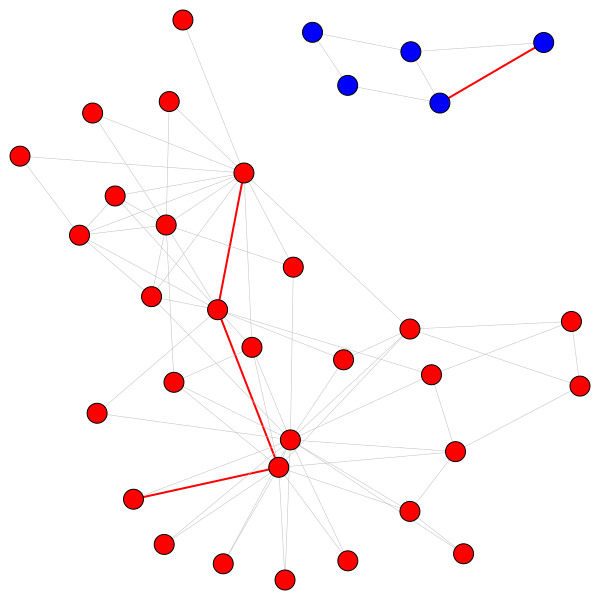

In [22]:
components = G.clusters()
G.vs[components[0]]['color'] = 'red'
G.vs[components[1]]['color'] = 'blue'
ig.plot(G)

Usually, networks tend to have one large component, and many smaller components. In empirical networks, it is therefore common practice to restrict any further analyses to the largest connected component. Because the difference between the largest connected component and the other components is usually quite large, the largest connected component is sometimes also called the *giant component*.

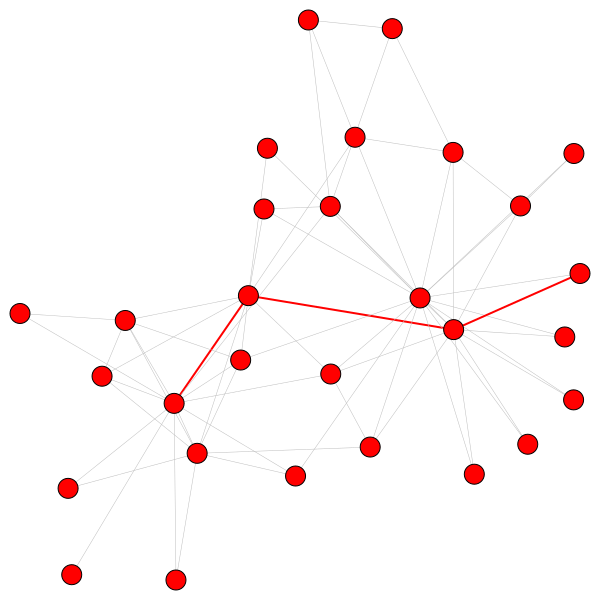

In [23]:
H = G.clusters().giant()
ig.plot(H, layout=H.layout_fruchterman_reingold())

## Cycles

If there are two paths going from one node to another node, we can join them together and make a *cycle*. We start again with a fresh graph.

In [24]:
G = ig.Graph.Famous('Zachary')
G['layout'] = G.layout_fruchterman_reingold()

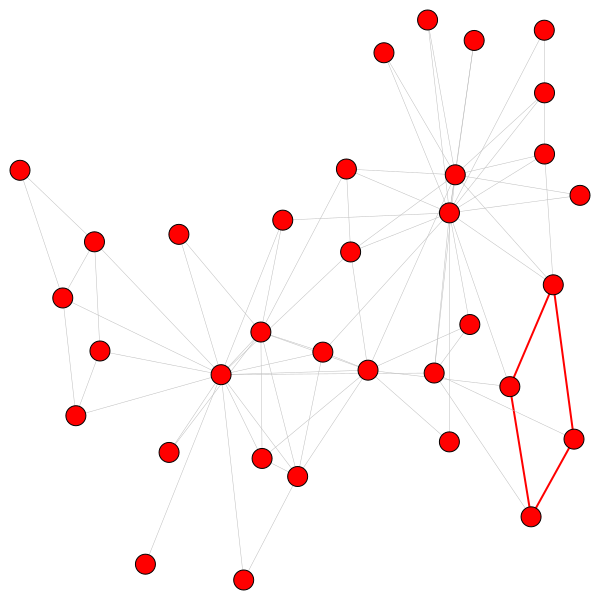

In [25]:
cycle = G.es[G.get_eids(path=(24, 25, 23, 27, 24))]

G.es['color'] = 'gray'
G.es['width'] = 0.5
cycle['color'] = 'red'
cycle['width'] = 2

ig.plot(G)

In [26]:
[(e.source, e.target) for e in cycle]

[(24, 25), (23, 25), (23, 27), (24, 27)]

This is a cycle of length 4, but longer cycles do exist in the graph. The smallest cycle of length 3 are of particular interest to the social sciences. A small group of three people is commonly called a *triad* in the social sciences. It is of particular interest because if two people have a friend in common, they are more likely to become friends themselves. This is known as *triadic closure*.

If there are many closed triads, i.e. many cycles of length 3, it suggests that many people have many friends in common. In particular, the network is then said to be *clustered*. The *clustering coefficient* for a node is defined as the proportion of neighbors that are connected amongst each other. A clustering coefficient of 1 then means that all the neighbors of a node are connected to each other, while a clustering coefficient of 0 means that no neigbhours are connected amongst each other. The overall clustering is then simply the average over the whole network.

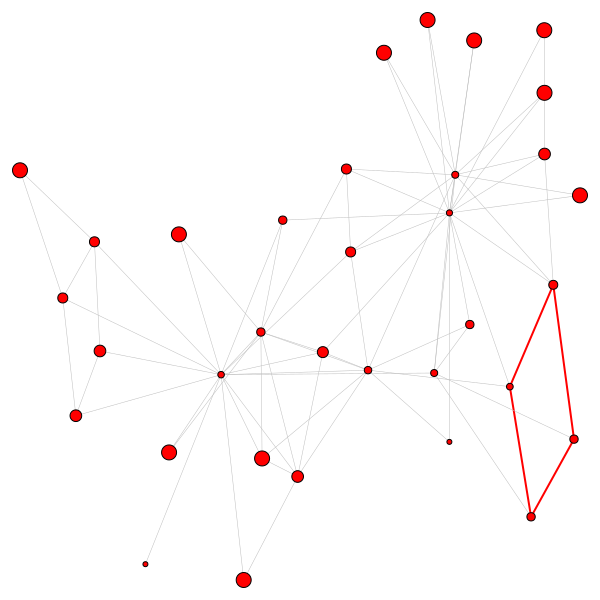

In [27]:
clustering = G.transitivity_local_undirected(mode="zero")

ig.plot(G, vertex_size=10*(np.array(clustering)+0.5))

As you can see, the nodes that are more clustered seem to be more peripheral. This is something that can be seen more
often. Nodes that have many neighbors usually have fewer connections between *all* their neighbors, so that they tend to have a lower clustering coefficient.

Nodes that have a higher clustering coefficient tend to be well embedded in the network. Nodes with a low clustering coefficient on the other hand tend to function as bridges, connecting different parts of the network. For example, when removing node 0 from the network, this disconnects the network.

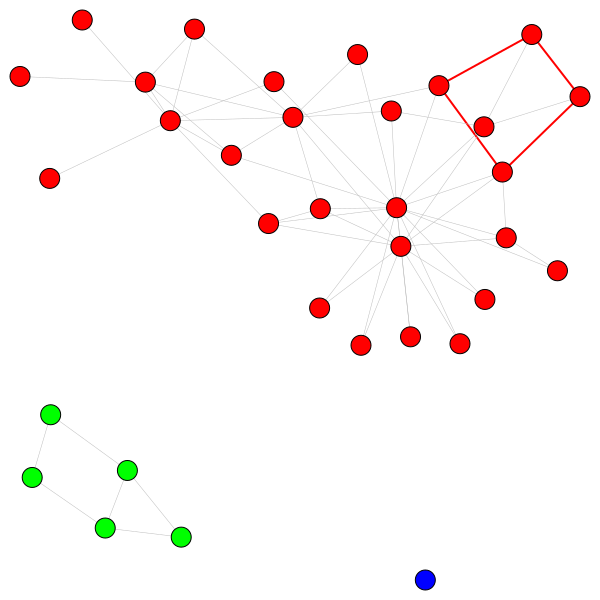

In [28]:
H = G.copy()
H.delete_vertices(0)
components = H.clusters()
ig.plot(components, layout=H.layout_fruchterman_reingold())

This means that node 0 functions as a bridge. In fact, this is the only node that acts as a bridge in this graph.

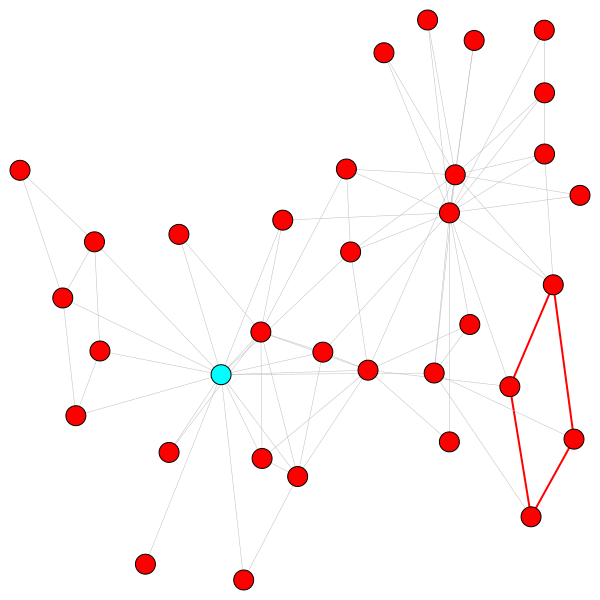

In [29]:
is_bridge = [False]*G.vcount()
for v in range(G.vcount()):
    H = G.copy()
    H.delete_vertices(v)
    is_bridge[v] = len(H.clusters()) > 1
    
ig.plot(G, vertex_color=is_bridge, palette=ig.RainbowPalette(2))